### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import itertools

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [3]:
data=pd.read_csv('Customer_Behaviour.csv')

#### Data Information

In [4]:
data.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


Dataset Preparation

In [6]:
data.isnull().sum()

User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

In [7]:
for col in data:
    print(f"{col}: {data[col].nunique()}")

User ID: 400
Gender: 2
Age: 43
EstimatedSalary: 117
Purchased: 2


In [8]:
data.describe()

,User ID,Age,EstimatedSalary,Purchased
count,4.000000e+02,400.000000,400.000000,400.000000
mean,1.569154e+07,37.655000,69742.500000,0.357500
std,7.165832e+04,10.482877,34096.960282,0.479864
min,1.556669e+07,18.000000,15000.000000,0.000000
25%,1.562676e+07,29.750000,43000.000000,0.000000
50%,1.569434e+07,37.000000,70000.000000,0.000000
75%,1.575036e+07,46.000000,88000.000000,1.000000
max,1.581524e+07,60.000000,150000.000000,1.000000


In [9]:
data.describe(include=[object])

,Gender
count,400
unique,2
top,Female
freq,204


In [10]:
data.drop(columns=['User ID'],axis=1,inplace=True)

In [11]:
data

,Gender,Age,EstimatedSalary,Purchased
0,Male,19,19000,0
1,Male,35,20000,0
2,Female,26,43000,0
3,Female,27,57000,0
4,Male,19,76000,0
...,...,...,...,...
395,Female,46,41000,1
396,Male,51,23000,1
397,Female,50,20000,1
398,Male,36,33000,0


In [12]:
from sklearn.preprocessing import LabelEncoder
ls=LabelEncoder()
data['Gender']=pd.DataFrame(ls.fit_transform(data['Gender']))

In [13]:
data

,Gender,Age,EstimatedSalary,Purchased
0,1,19,19000,0
1,1,35,20000,0
2,0,26,43000,0
3,0,27,57000,0
4,1,19,76000,0
...,...,...,...,...
395,0,46,41000,1
396,1,51,23000,1
397,0,50,20000,1
398,1,36,33000,0


### Exploratory Data Analysis

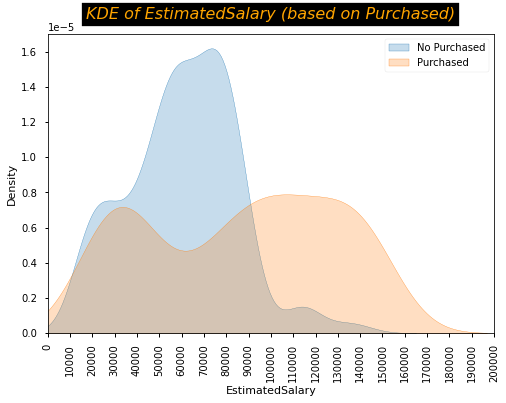

In [14]:
# check distribution of EstimatedSalary (based on Purchased)
font = {'fontsize':16, 'fontstyle':'italic', 'backgroundcolor':'black', 'color':'orange'}
%matplotlib inline
plt.style.use('seaborn-notebook')
sns.kdeplot(data.loc[data['Purchased'] == 0, 'EstimatedSalary'], label='No Purchased', shade=True)
sns.kdeplot(data.loc[data['Purchased'] == 1, 'EstimatedSalary'], label='Purchased', shade=True)
plt.title('KDE of EstimatedSalary (based on Purchased)', fontdict=font, pad=15)
plt.xticks(np.arange(0,200001,10000), rotation=90)
plt.xlim([0,200001])
plt.legend()
plt.show()

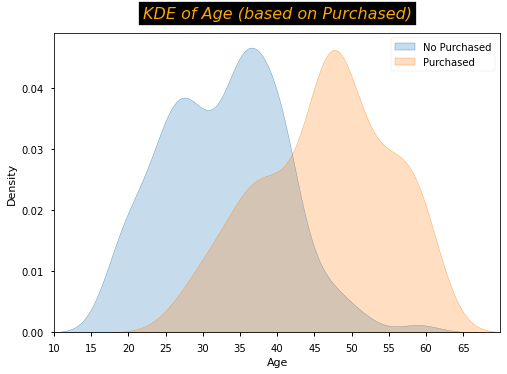

In [15]:
# check distribution of Purchased (based on Purchased)
%matplotlib inline
plt.style.use('seaborn-notebook')
sns.kdeplot(data.loc[data['Purchased'] == 0, 'Age'], label='No Purchased', shade=True)
sns.kdeplot(data.loc[data['Purchased'] == 1, 'Age'], label='Purchased', shade=True)
plt.title('KDE of Age (based on Purchased)', fontdict=font, pad=15)
plt.xticks(np.arange(0,70,5))
plt.xlim([10,70])
plt.legend()
plt.show()

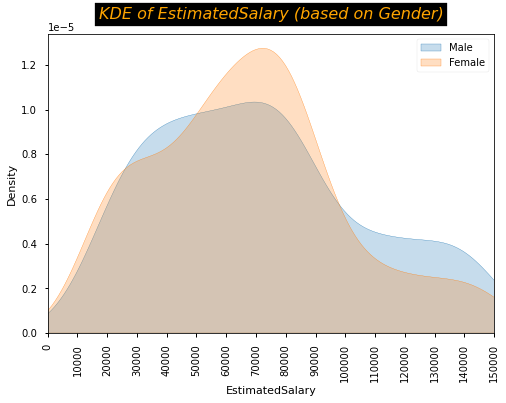

In [17]:
# check distribution of EstimatedSalary (based on Gender)
%matplotlib inline
plt.style.use('seaborn-notebook')
sns.kdeplot(data.loc[data['Gender'] == 0, 'EstimatedSalary'], label='Male', shade=True)
sns.kdeplot(data.loc[data['Gender'] == 1, 'EstimatedSalary'], label='Female', shade=True)
plt.title('KDE of EstimatedSalary (based on Gender)', fontdict=font, pad=15)
plt.xticks(np.arange(0,150001,10000), rotation=90)
plt.xlim([0,150001])
plt.legend()
plt.show()

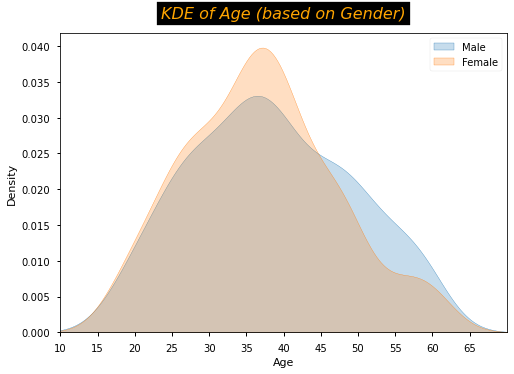

In [18]:
# check distribution of Age (based on Gender)
%matplotlib inline
plt.style.use('seaborn-notebook')
sns.kdeplot(data.loc[data['Gender'] == 0, 'Age'], label='Male', shade=True)
sns.kdeplot(data.loc[data['Gender'] == 1, 'Age'], label='Female', shade=True)
plt.title('KDE of Age (based on Gender)', fontdict=font, pad=15)
plt.xticks(np.arange(0,70,5))
plt.xlim([10,70])
plt.legend()
plt.show()

According to above kde plots:

Most people whose income is between 40000 and 90000 don't decide to purchase a product.
Most people whose income is between 40000 and 90000 don't decide to purchase a product.
Most people who decide to purchase a product are older than people who don't decide to purchase a product.
People over the age of 43 are often interested in purchase a product.
Based on Gender for each male or female, kde is almost same.

### UNIVARIATE ANALYSIS

In [19]:
data.describe()

,Gender,Age,EstimatedSalary,Purchased
count,400.000000,400.000000,400.000000,400.000000
mean,0.490000,37.655000,69742.500000,0.357500
std,0.500526,10.482877,34096.960282,0.479864
min,0.000000,18.000000,15000.000000,0.000000
25%,0.000000,29.750000,43000.000000,0.000000
50%,0.000000,37.000000,70000.000000,0.000000
75%,1.000000,46.000000,88000.000000,1.000000
max,1.000000,60.000000,150000.000000,1.000000


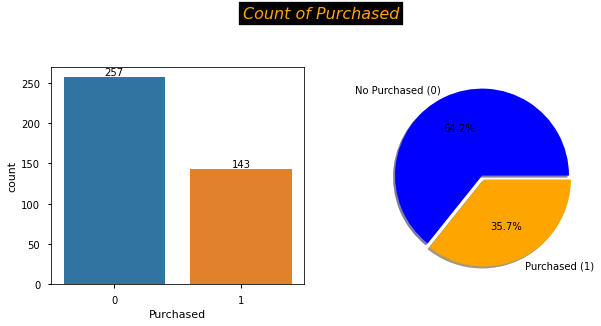

In [21]:
# count based on Purchased (countplot)
fig, axes = plt.subplots(1,2,figsize=(10,4))

sns.countplot(data=data, x='Purchased', ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)

# count based on Purchased (pie chart)
slices = data.Purchased.value_counts().values
activities = ['No Purchased (0)', 'Purchased (1)']
axes[1].pie(slices, labels=activities, colors=['blue','orange'], shadow=True, explode=[0,0.05], autopct='%1.1f%%')

plt.suptitle('Count of Purchased', y=1.09, **font)
plt.show()

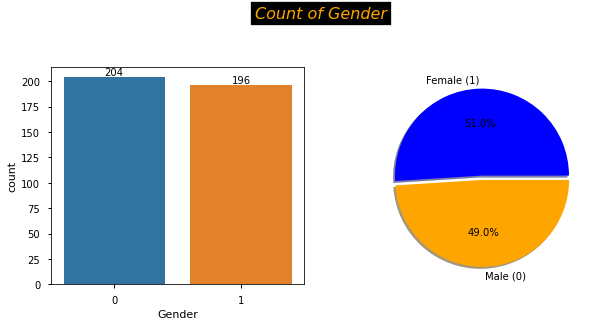

In [22]:
# count based on Gender (countplot)
fig, axes = plt.subplots(1,2,figsize=(10,4))

sns.countplot(data=data, x='Gender', ax=axes[0])
for container in axes[0].containers:
    axes[0].bar_label(container)

# count based on Gender (pie chart)
slices = data.Gender.value_counts().values
activities = ['Female (1)', 'Male (0)']
axes[1].pie(slices, labels=activities, colors=['blue','orange'], shadow=True, explode=[0,0.05], autopct='%1.1f%%')

plt.suptitle('Count of Gender', y=1.09, **font)
plt.show()

According to above barplots and tabel:

The number of male and female is almost the same
he number of people who decide to purchased a product is less than the number of people who do not decide to purchased a product.

### Bivariate Analysis

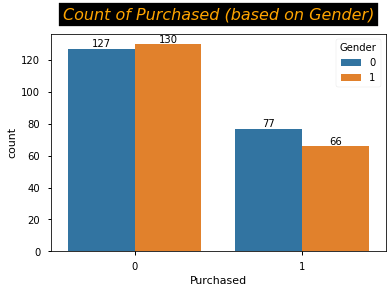

In [23]:
%matplotlib inline
ax = sns.countplot(data=data, x='Purchased', hue='Gender')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count of Purchased (based on Gender)', fontdict=font, pad=15)
plt.show()

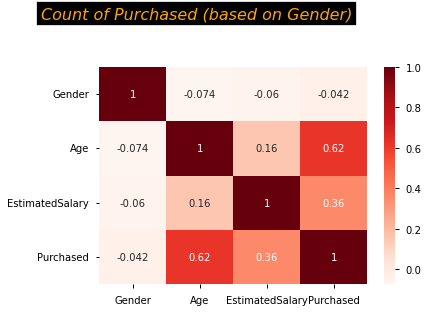

In [24]:
sns.heatmap(data.corr(), cmap='Reds', annot=True)
plt.suptitle('Count of Purchased (based on Gender)', y=1.09, x=0.35, **font)
plt.show()

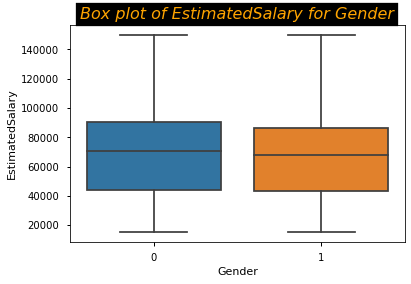

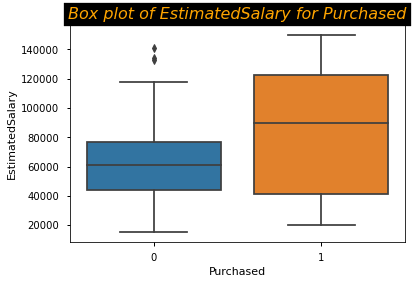

In [25]:
# draw box plot of Estimated salary for male(0) or female(1) Gender
# draw box plot of Estimated salary for no purchased(0) or purchased(1)
for col in ['Gender', 'Purchased']:
    sns.boxplot(data=data, x=col, y='EstimatedSalary')
    plt.title(f'Box plot of EstimatedSalary for {col}', fontdict=font)
    plt.show()

According to above plots:

Among the people who decide to purchase a product, there are more female than male, but among the people who do not decide to purchase a product, there are more male.
The highest correlation is between Purchased and Age (0.62).
The average EstimatedSalary of people who decide to purchase a product is higher than people who do not decide to purchase a product.
Average EstimatedSalary of male and female do not differ much.

### Multivariate Analysis 

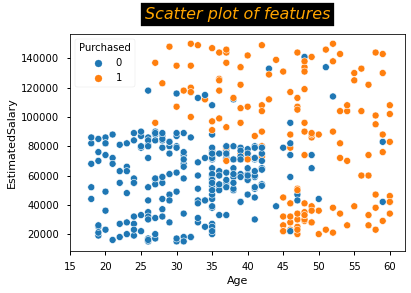

In [26]:
%matplotlib inline
# check feature correlation
sns.scatterplot(data=data,x='Age', y='EstimatedSalary', hue='Purchased',)
plt.title('Scatter plot of features', y=1.04, fontdict=font)
plt.xticks(np.arange(15,65,5))
plt.show()

In [27]:
fig = px.scatter_3d(
        data_frame=data,
        x='Age',
        y='EstimatedSalary',
        z='Gender',
        color='Purchased',
        template='ggplot2',
        opacity=0.6,
        height=700,
        title=f'3d scatter based on Age, EstimatedSalary, Gender and Purchased'
)

pio.show(fig)

In [28]:
# check mean of EstimatedSalary based on Gender and Purchased
results = pd.pivot_table(data=data, index='Purchased', columns='Gender', values='EstimatedSalary')
results.style.background_gradient(cmap='summer_r')


Gender,0,1
Purchased,,
0,61480.314961,59630.769231
1,88714.285714,83424.242424


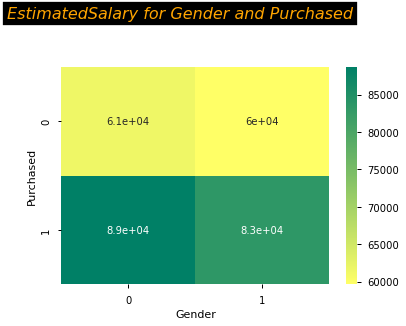

In [29]:
# show result in heatmap
sns.heatmap(results, cmap='summer_r', annot=True)
plt.suptitle('EstimatedSalary for Gender and Purchased', y=1.09, x=0.4, **font)
plt.show()

In [30]:
# check mean of Age based on Gender and Purchased
results = pd.pivot_table(data=data, index='Purchased', columns='Gender', values='Age')
results.style.background_gradient(cmap='summer_r')

Gender,0,1
Purchased,,
0,33.110236,32.484615
1,47.155844,45.500000


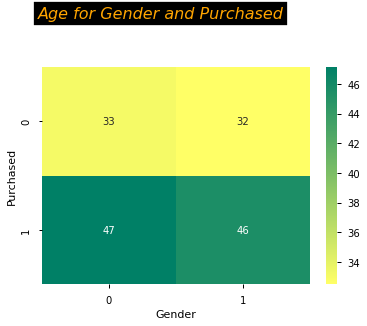

In [31]:
# show result in heatmap
sns.heatmap(results, cmap='summer_r', annot=True)
plt.suptitle('Age for Gender and Purchased', y=1.09, x=0.4, **font)
plt.show()

According to above plots:

People with young age and low EstimatedSalary often do not have a decision to purchase product.
People with a EstimatedSalary of more than 100000, regardless of their Age, often decide to purchase product.
People over the age of 45, regardless of their EstimatedSalary, are more likely to pruchase a product.
These plots also confirm the previous results

### Model Prediction Using Naive Bayes

In [34]:
# standardize EstimatedSalary and Age with StandardScaler
df2 = data.copy()
scaler = MinMaxScaler(feature_range=(18,60)).fit(data[['EstimatedSalary']])
df2['EstimatedSalary'] = scaler.transform(df2['EstimatedSalary'].values.reshape(-1,1))
df2

C:\Users\aasth\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



,Gender,Age,EstimatedSalary,Purchased
0,1,19,19.244444,0
1,1,35,19.555556,0
2,0,26,26.711111,0
3,0,27,31.066667,0
4,1,19,36.977778,0
...,...,...,...,...
395,0,46,26.088889,1
396,1,51,20.488889,1
397,0,50,19.555556,1
398,1,36,23.600000,0


In [35]:
# define x (features) and y (target)
x = np.asanyarray(df2.drop('Purchased', axis=1))
y = df2.Purchased.values.reshape(-1,1)

In [41]:
PR1 = []
TPR1 = []
FPR0 = []
TPR0 = []
ACC_test = []
ACC_train = []
Recall = []
Precision = []
F1 = []
FPR1=[]
def plot_confusion_matrix2(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
        cm(array): confusion matrix
        classes(dictionary): classes in our target
    """
    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt ='d'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# --------------------------------------------------------------------------------------

def Perform_cross_val(model, k, x, y, scoring):
    """
    perform cross validation
        model: logistic model
        k(scaler): the value for n_splits in KFold()
        x(DataFrame or array):  x_train
        y(DataFrame or array): y_train
        scoring(string): an approach for evaluation in cross validation
    """

    kf = KFold(n_splits=k)
    cv_results = cross_val_score(model, x, y, cv=kf, scoring=scoring)
    cv_mean = np.mean(cv_results)
    print('-'*20, f"CV for k={k}, scoring={scoring}", '-'*20)
    print(f"CV mean: {cv_mean}")
    print(f"CV results: {cv_results}\n")

# --------------------------------------------------------------------------------------

def find_fold_index(k, x):
    """
    Find fold index in kfold
        k(scaler): the value used for n_splits in KFold()
        x(DataFrame or array): x_train
    """

    my_fold_index = []
    j=1
    for _ , test in KFold(k).split(x):

        my_fold_index = []
        for i in test:
            my_fold_index.append(i)
        print(f"fold {j}: [{my_fold_index[0]},{my_fold_index[-1]}]")
        print(20*'-')
        j += 1

# --------------------------------------------------------------------------------------

def plot_results(FPR0, TPR0, FPR1, TPR1, ACC_test, ACC_train, Recall, Precision, F1):
    """
    draw ROC curve and plot of Recall, precision, f1 score etc.
        FPR0(list): list of False Positive Rate for class 0
        TPR0(list): list of True Positive Rate for class 0
        FPR1(list): list of Flase Positive Rate for class 1
        TPR1(list): list of True Positive Rate for class 1
        ACC(list): list of accuracy of models
        Recall(list): list of recall score of models
        Precision(list): list of Precision score of models
        F1(list): list of F1 score of models 
    """
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    # plot model evaluation
    ax[0].set_title('Model Evaluation Results', fontdict=font, y=1.02)
    sns.lineplot(data=pd.DataFrame({'accoracy': ACC_test, 'Recall': Recall,
                                    'Precision': Precision, 'F1 score': F1}), 
                                    markers=True, ax=ax[0])
    ax[0].set_xlabel('M')
    ax[0].set_ylabel('Evaluation')
    ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=True)

    # plot model evaluation
    ax[1].set_title('Model Accuracy Results for train and test', fontdict=font, y=1.02)
    sns.lineplot(data=pd.DataFrame({'test accuracy': ACC_test, 'train accuracy': ACC_train}), 
                                    markers=True, ax=ax[1])
    ax[1].set_xlabel('M')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=True)
    plt.show()

    # plot ROC curve for class 1
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    i=1
    ax[0].set_title('ROC Curve of Class 1', fontdict=font, y=1.02)
    for fpr , tpr in zip(FPR1, TPR1):
        ax[0].plot(fpr, tpr, label=f"ROC curve of model{i} (AUC = {round(metrics.auc(fpr, tpr),3)})")
        i += 1
        ax[0].set_xlabel('FPR')
        ax[0].set_ylabel('TPR')
    ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=True)
        
    # plot ROC curve for class zero
    i=1
    ax[1].set_title('ROC Curve of Class 0', fontdict=font, y=1.02)
    for fpr , tpr in zip(FPR0, TPR0):
        ax[1].plot(fpr, tpr, '--', label=f"ROC curve of model{i} (AUC = {round(metrics.auc(fpr, tpr),3)})")
        i += 1
        ax[1].set_xlabel('FPR')
        ax[1].set_ylabel('TPR')
    ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
        fancybox=True, shadow=True)
    
    plt.show()

# --------------------------------------------------------------------------------------

def modeling(x, y, test_size, classes, is_add=1 ):

    # split data to train and test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=0)
    print(20*'-', 'Shape', 20*'-')
    print(f"x_train: {x_train.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"x_test: {x_test.shape}")
    print(f"y_test: {y_test.shape}")
    


    # define model and fit model
    clf = MultinomialNB()
    clf.fit(x_train, y_train.ravel())

    # prediction and results
    y_pred_train = clf.predict(x_train)
    y_pred_test = clf.predict(x_test)
    y_proba_train = clf.predict_proba(x_train)
    y_proba_test = clf.predict_proba(x_test)

    cm = metrics.confusion_matrix(y_test, y_pred_test)
    fpr1, tpr1, _ = metrics.roc_curve(y_test, y_proba_test[:,1])
    fpr0, tpr0, _ = metrics.roc_curve(y_test, y_proba_test[:,0])
    acc_test = metrics.accuracy_score(y_test, y_pred_test)
    acc_train = metrics.accuracy_score(y_train, y_pred_train)
    rec = metrics.recall_score(y_test, y_pred_test)
    pre = metrics.precision_score(y_test, y_pred_test)
    f1 = metrics.f1_score(y_test, y_pred_test)
     # append results
    if is_add == 1:
        FPR0.append(fpr0)
        TPR0.append(tpr0)
        FPR1.append(fpr1)
        TPR1.append(tpr1)
        ACC_test.append(acc_test)
        ACC_train.append(acc_train)
        Recall.append(rec)
        Precision.append(pre)
        F1.append(f1)

    plot_results(FPR0, TPR0, FPR1, TPR1, ACC_test, ACC_train, Recall, Precision, F1)

    # Evaluation model
    print('-'*20 , 'Confusion Matrix', '-'*20)
    print(cm)
    plot_confusion_matrix2(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
    # or use plot_confusion_matrix from sklearn.metrics
    print('-'*20 , 'Classification Report', '-'*20)
    print(metrics.classification_report(y_test, y_pred_test, target_names=classes), '\n')
    print(f"Jaccard Score: {metrics.jaccard_score(y_test, y_pred_test)}", '\n')

    # print other result about predicted data
    return clf, acc_test, acc_train


-------------------- Shape --------------------
x_train: (320, 3)
y_train: (320, 1)
x_test: (80, 3)
y_test: (80, 1)


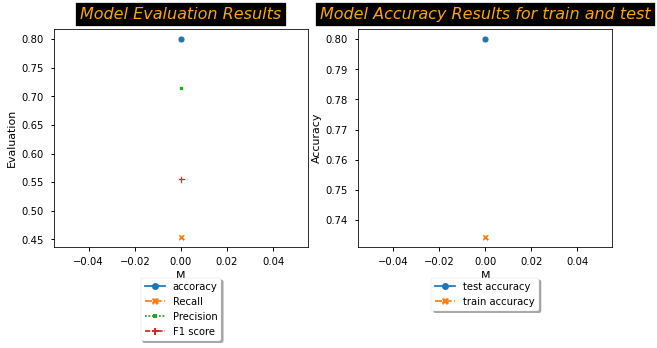

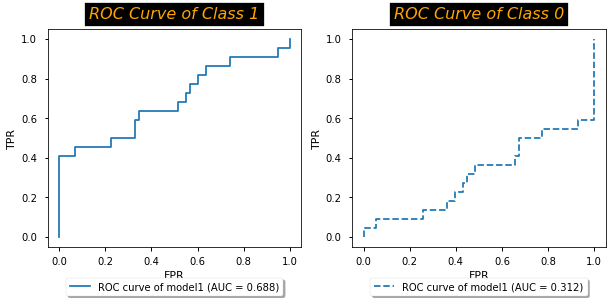

-------------------- Confusion Matrix --------------------
[[54  4]
 [12 10]]


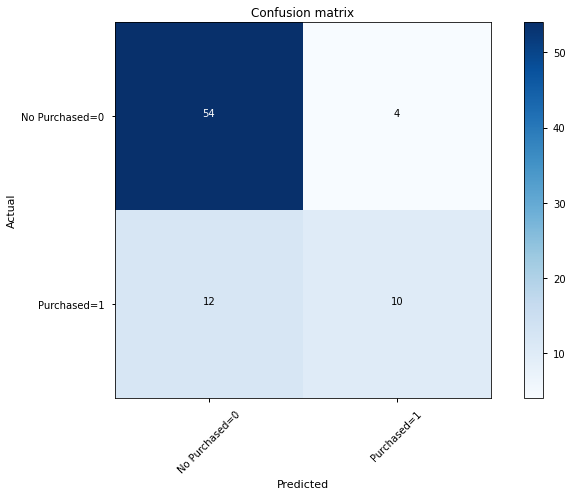

-------------------- Classification Report --------------------
                precision    recall  f1-score   support

No Purchased=0       0.82      0.93      0.87        58
   Purchased=1       0.71      0.45      0.56        22

      accuracy                           0.80        80
     macro avg       0.77      0.69      0.71        80
  weighted avg       0.79      0.80      0.78        80
 

Jaccard Score: 0.38461538461538464 



In [42]:
# Now create first model
clf1, acc_test1, acc_train1 = modeling(x, y, 0.2, ['No Purchased=0', 'Purchased=1'])

In [43]:
Perform_cross_val(clf1, 10, x, y, scoring='accuracy')

-------------------- CV for k=10, scoring=accuracy --------------------
CV mean: 0.685
CV results: [0.95  0.85  0.875 0.75  0.875 0.425 0.525 0.55  0.65  0.4  ]



C:\Users\aasth\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\aasth\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\aasth\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\aasth\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\aasth\anaconda3\lib\site-packages\sklearn\utils\validat

Folds 6 and 10 are more different from the average than other folds. Therefore, maybe by removing them, the model will be better:

In [44]:
find_fold_index(10, x)

fold 1: [0,39]
--------------------
fold 2: [40,79]
--------------------
fold 3: [80,119]
--------------------
fold 4: [120,159]
--------------------
fold 5: [160,199]
--------------------
fold 6: [200,239]
--------------------
fold 7: [240,279]
--------------------
fold 8: [280,319]
--------------------
fold 9: [320,359]
--------------------
fold 10: [360,399]
--------------------


In [45]:
df3 = df2.drop(df2.index[np.r_[200:239+1, 360:399+1]], axis=0)

In [46]:
x2 = np.asanyarray(df3.drop('Purchased', axis=1))
y2 = df3.Purchased.values.reshape(-1,1)

-------------------- Shape --------------------
x_train: (256, 3)
y_train: (256, 1)
x_test: (64, 3)
y_test: (64, 1)


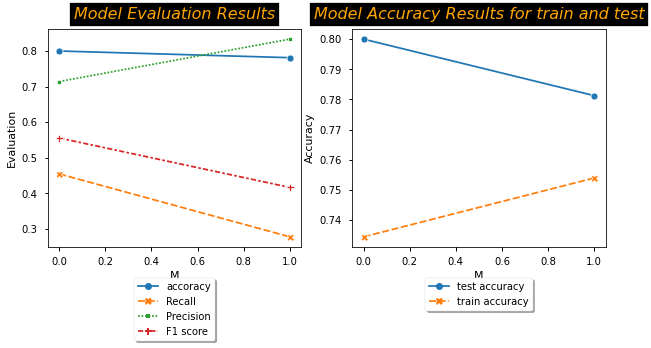

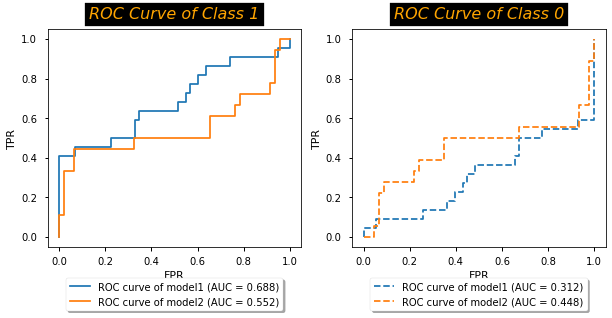

-------------------- Confusion Matrix --------------------
[[45  1]
 [13  5]]


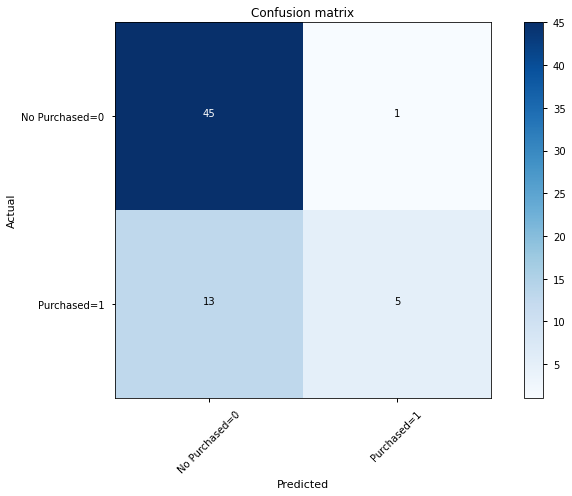

-------------------- Classification Report --------------------
                precision    recall  f1-score   support

No Purchased=0       0.78      0.98      0.87        46
   Purchased=1       0.83      0.28      0.42        18

      accuracy                           0.78        64
     macro avg       0.80      0.63      0.64        64
  weighted avg       0.79      0.78      0.74        64
 

Jaccard Score: 0.2631578947368421 



In [47]:
clf2, acc_test2, acc_train2 = modeling(x2, y2, 0.2, classes=['No Purchased=0', 'Purchased=1'])

Now the performance of the model has improved and reached an accuracy of 0.81. As shown in the confusion matrix and the classification report, due to the lack of data in class 1, the accuracy of this class is low, and the 12 people who decided to purchase were wrongly predicted as class zero. However, the accuracy achieved is good.

In [48]:
%matplotlib inline
x_train, x_test, y_train, y_test = train_test_split(x2, y2, test_size=0.2, random_state=0)
x_test = np.concatenate((x_test, y_test), axis=1)
x_test = pd.DataFrame(x_test, columns=['Gender', 'Age', 'EstimatedSalary', 'Purchased'])

fig = px.scatter_3d(
    data_frame= x_test,
    x=x_test.Age,
    y=x_test.EstimatedSalary,
    z=x_test.Purchased,
    color=clf2.predict(x_test.drop('Purchased', axis=1)).astype(str),
    color_discrete_sequence={0:'red', 1:'green'},
    template='ggplot2',
    opacity=0.6,
    height=700,
    title=f'Visualization Performance of clf2 in Predicting')

pio.show(fig)

C:\Users\aasth\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but MultinomialNB was fitted without feature names



In [49]:
clf2.predict(x_test.drop('Purchased', axis=1))

C:\Users\aasth\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but MultinomialNB was fitted without feature names



array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In the figure drawn above, it is very clear that at the bottom of the cube where all the data are correctly predicted and all are red, but at the top of the cube where all the circles should be green, red circles are also seen, which indicates the wrong prediction.

In [50]:
# fit final model on all of data (train + test)
final_model = MultinomialNB()
final_model.fit(x2, y2)

# new sample data
new_sample = pd.DataFrame({'Gender': [1], 'Age': [18], 'EstimatedSalary': [70000]})
print(f"Gender: {new_sample['Gender'].values[0]}\n"
      f"Age: {new_sample['Age'].values[0]}\n"
      f"EstimatedSalary: {new_sample['EstimatedSalary'].values[0]}")

# Satandardize new_sample by use scaler
new_sample['EstimatedSalary'] = scaler.transform(new_sample[['EstimatedSalary']])
ns = np.asanyarray(new_sample)

# predict new sample data
result = final_model.predict(ns)
print('='*38)
print(f"class {result}")

Gender: 1
Age: 18
EstimatedSalary: 70000
class [0]


C:\Users\aasth\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

